# Generating Brown Dwarf / Directly Imaged Planet Emission Spectra

### (work in progress)

This tutorial demonstrates how to compute the direct emission spectrum of a directly imaged object (brown dwarf or directly imaged exoplanet).

### System properties

For a directly observed object, we want to compute a model of the flux observed at Earth, $F_p$. We don't have to consider a star in this case, but we do have to provide the distance to the system.

In [1]:
from POSEIDON.core import create_planet
from POSEIDON.constants import R_J
from scipy.constants import parsec as pc

#***** Define planet / brown dwarf properties *****#

planet_name = 'GJ 570 D'  # Planet name used for plots, output files etc.

R_p = 1.1481664*R_J   # Planetary radius (m)
log_g = 4.76          # log_10 gravitational field of planet (cm/s^2)
d = 5.882*pc          # Distance to system (m)
d_err = 0.00311*pc    # Error in a priori system distance

# Create the planet object
planet = create_planet(planet_name, R_p, log_g = log_g, d = d, d_err = d_err)

# No star in this case
star = None

### A Basic T Dwarf Model



We'll make a simple cloud-free T dwarf model based on the retrieved parameters from Line+2015.

In [2]:
from POSEIDON.core import define_model

#***** Define model *****#

model_name = 'T-dwarf_Line_2015'  # Model name used for plots, output files etc.

bulk_species = ['H2', 'He']
param_species = ['H2O', 'CH4', 'CO', 'CO2', 'NH3', 'HCN', 'Na', 'K']

# Create the model object
model = define_model(model_name, bulk_species, param_species, 
                     object_type = 'directly_imaged', gravity_setting = 'free',
                     PT_profile = 'slope')

# Check the free parameters defining this model
print("Free parameters: " + str(model['param_names']))

Free parameters: ['R_p_ref' 'log_g' 'd' 'T_phot' 'Delta_T_10-1mb' 'Delta_T_100-10mb'
 'Delta_T_1-0.1b' 'Delta_T_3.2-1b' 'Delta_T_10-3.2b' 'Delta_T_32-10b'
 'Delta_T_100-32b' 'log_H2O' 'log_CH4' 'log_CO' 'log_CO2' 'log_NH3'
 'log_HCN' 'log_Na' 'log_K']


In [3]:
import numpy as np
from POSEIDON.core import make_atmosphere

# Specify the pressure grid of the atmosphere
P_min = 1.0e-3    # 1 mbar
P_max = 100       # 100 bar
N_layers = 100    # 100 layers

# We'll space the layers uniformly in log-pressure
P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)

# Specify the reference pressure and radius
P_ref = 10.0   # Reference pressure (bar)
R_p_ref = R_p  # Radius at reference pressure

# Provide a specific set of model parameters for the atmosphere 
#PT_params = np.array([300, 2100])     # T_high, T_deep
#PT_params = np.array([0.60, 0.125, -2.0, -3.0, 2.5, 1200])
PT_params = np.array([1500.0, 100, 200, 150, 300, 50, 400, 700])
log_X_params = np.array([[-3.45, -3.40, -7.53, -7.76, -4.64, -20.0, -5.50, -6.69]])

# Generate the atmosphere
atmosphere = make_atmosphere(planet, model, P, P_ref, R_p_ref, PT_params, 
                             log_X_params, log_g = log_g)

Let's see what our atmosphere looks like.

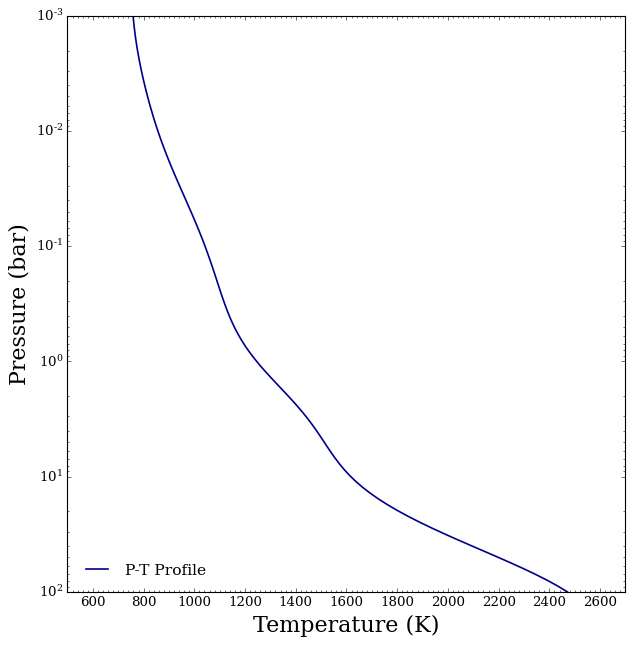

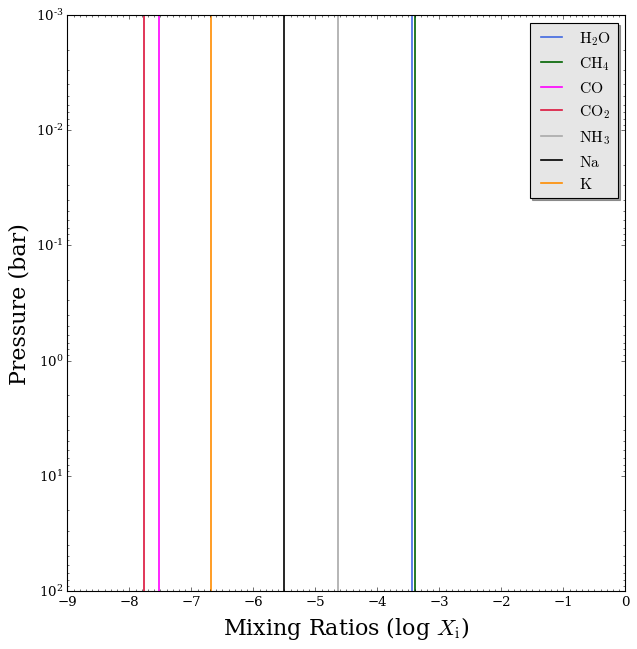

In [4]:
from POSEIDON.visuals import plot_PT, plot_chem

# Produce plots of atmospheric properties
fig_PT = plot_PT(planet, model, atmosphere, log_P_max = 2.0)
fig_chem = plot_chem(planet, model, atmosphere, 
                     plot_species = ['H2O', 'CH4', 'CO', 'CO2', 'NH3', 'Na', 'K'],
                     log_X_min = -9, log_P_max = 2.0)

**Pre-load Opacities**


In [5]:
from POSEIDON.core import read_opacities, wl_grid_constant_R

#***** Wavelength grid *****#
 
wl_min = 1.1      # Minimum wavelength (um)
wl_max = 1.7      # Maximum wavelength (um)
R = 15000         # Spectral resolution of grid

wl = wl_grid_constant_R(wl_min, wl_max, R)

#***** Read opacity data *****#

opacity_treatment = 'opacity_sampling'

# Define fine temperature grid (K)
T_fine_min = 200     # 400 K lower limit suffices for a typical hot Jupiter
T_fine_max = 2400    # 2000 K upper limit suffices for a typical hot Jupiter
T_fine_step = 10     # 10 K steps are a good tradeoff between accuracy and RAM

T_fine = np.arange(T_fine_min, (T_fine_max + T_fine_step), T_fine_step)

# Define fine pressure grid (log10(P/bar))
log_P_fine_min = -4.0   # 1 ubar is the lowest pressure in the opacity database
log_P_fine_max = 2.0    # 100 bar is the highest pressure in the opacity database
log_P_fine_step = 0.2   # 0.2 dex steps are a good tradeoff between accuracy and RAM

log_P_fine = np.arange(log_P_fine_min, (log_P_fine_max + log_P_fine_step), 
                       log_P_fine_step)

# Now we can pre-interpolate the sampled opacities (may take up to a minute)
opac = read_opacities(model, wl, opacity_treatment, T_fine, log_P_fine)

Reading in cross sections in opacity sampling mode...
H2-H2 done
H2-He done
H2-CH4 done
CO2-H2 done
CO2-CO2 done
CO2-CH4 done
H2O done
CH4 done
CO done
CO2 done
NH3 done
HCN done
Na done
K done
Opacity pre-interpolation complete.


### Computing Emission Spectra

Now we can generate the emission spectrum of our brown dwarf.

[3.92131926e-08 2.65308267e-08 4.35066118e-08 ... 2.22040470e-10
 1.72697536e-10 1.85193620e-10]


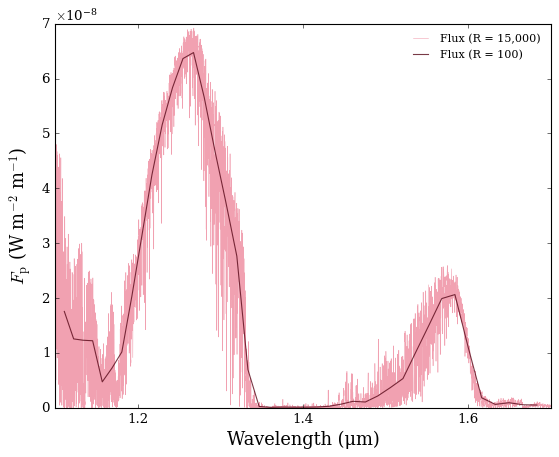

In [6]:
from POSEIDON.core import compute_spectrum
from POSEIDON.visuals import plot_Fp

# Generate planet surface flux
Fp = compute_spectrum(planet, star, model, atmosphere, opac, wl, 
                      spectrum_type = 'direct_emission')

print(Fp)

# Produce figure and save to file
fig = plot_Fp(planet, model, Fp, wl, R_to_bin = 100)

In [10]:
%timeit compute_spectrum(planet, star, model, atmosphere, opac, wl, spectrum_type = 'direct_emission')

37.4 ms ± 288 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
3.5.1
